In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.distributions as dists
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from models import *
import utils as ut

In [26]:
# transforms
lst_trans = []
lst_trans.append(
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]))

lst_trans.append(
    transforms.Compose([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
    ]))
transform = ut.Transform(lst_trans)

# dataset
dataset_train = MNIST(root='./data', train=True, transform=transform)
dataset_test = MNIST(root='./data', train=False, transform=transform)

# loader
len_batch = 32
loader_train = DataLoader(dataset_train, batch_size=len_batch, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=len_batch, shuffle=True)

# device
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# model
model = AE_MNIST(2).to(device)

# optim
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3, 
                             weight_decay=5e-4)

# estimation
loss = nn.BCELoss()

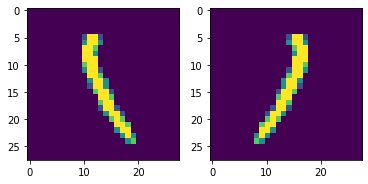

In [25]:
# plot loader
fig, ax = plt.subplots(1, 2)
for i, (lst_x, _) in enumerate(loader_test):
    x = lst_x[0]
    ax[0].imshow(x[0, 0])
    x = lst_x[1]
    ax[1].imshow(x[0, 0])
    break

In [27]:
log = {
    'loss_train': [],
    'loss_test': [],
}

for epoch in range(10):
    # train
    lst_l = []
    for lst_x, _ in loader_test:
        xi = lst_x[0]
        xj = lst_x[1]
        zi = model(xi)['z']
        zj = model(xj)['z']
        x = x.to(device)
        out = model(x)
        l = loss(out['x_'], x)
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()
        lst_l.append(l.item())
    log['loss_train'].append(np.mean(lst_l))
    # test
    lst_l = []
    with torch.no_grad():
        for x, _ in loader_test:
            x = x.to(device)
            out = model(x)
            l = loss(out['x_'], x)
            lst_l.append(l.item())
        
    log['loss_test'].append(np.mean(lst_l))
    # log
    print(
        f"epoch: {epoch+1}",
        f"train: {log['loss_train'][-1]: .5f}", 
        f"test: {log['loss_test'][-1]: .5f}")
    # plot
    if (epoch+1)%2 == 0:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x[0, 0].cpu())
        x_ = out['x_'].cpu().detach().reshape(-1, 1, 28, 28)
        ax[1].imshow(x_[0, 0])
        plt.show()

torch.Size([32, 1, 28, 28])


NameError: name 'afa' is not defined

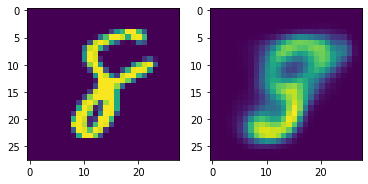

In [30]:
# plot encoder decoder
fig, ax = plt.subplots(1, 2)
for i, (x, _) in enumerate(loader_test):
    ax[0].imshow(x[0, 0])
    x = x.to(device)
    x_ = model(x)['x_']
    x_ = x_.cpu().detach().reshape(-1, 1, 28, 28)
    ax[1].imshow(x_[0, 0])
    plt.show()
    break

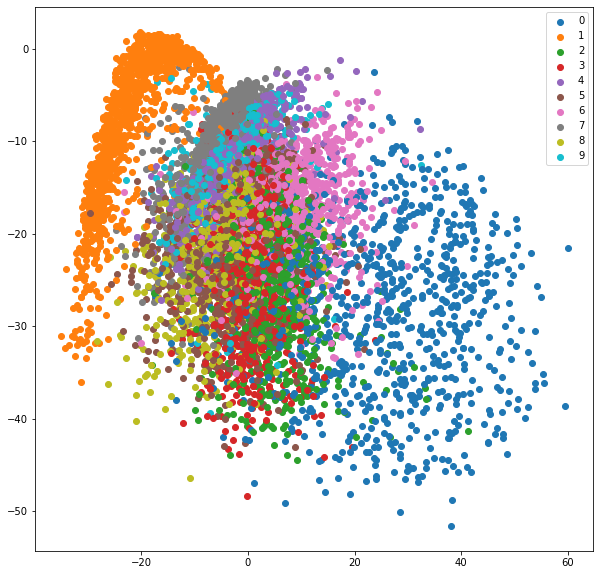

In [27]:
# plot encoder
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(loader_test):
    x = x.to(device)
    z = model.encode(x)
    z = z.cpu().detach()
    y = y.cpu()
    for label in range(10):
        idx = y == label
        plt.scatter(z[idx,0], z[idx,1])
    plt.legend(np.arange(10, dtype=np.int32))
plt.show()